# **PROYECTO PREDICTIVO DE CANCER DE MAMA**


## **Modelos l - Proyecto Sustituto (2025-1)**

Andres Dario Higuita Perez - C.C: 1022099411 - adario.higuita@udea.edu.co

### **Basado en Proyecto de Kaggle:**

**Competición:**
https://www.kaggle.com/competitions/rsna-breast-cancer-detection/code?competitionId=39272&sortBy=voteCount&excludeNonAccessedDatasources=true

**NoteBook:**
https://www.kaggle.com/code/radek1/eda-training-a-fast-ai-model-submission


**Profesor: RAUL RAMOS POLLAN**

**UNIVERSIDAD DE ANTIOQUIA**

*Ejecutar el notebook con googleColab prioritariamente para una correcta conexión a Drive institucional...*


## **Paso a paso de ejecución del proyecto**

1. Se realiza la instalación librerías necesarias para la correcta ejecución del los siguientes pasos.


*Ignorar advertencias de conflicto de dependencias, ya que es un conflicto dificil de resolver en la versiones de colab, mas sin embargo los bloques de codigo se ejecutan sin problema en su mayoria y solo hay un paso que puede fallar pero tiene solución indicada.*

In [ ]:
!pip install -Uqq numpy==1.24.4 fastai==2.7.12 pydicom==2.4.4 pylibjpeg pylibjpeg-libjpeg
!apt-get install -y python3-gdcm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-gdcm is already the newest version (3.0.10-1build2).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


2. Se realiza ejecución de codigo para la conexión a Drive donde estarán alojados los archivos de train y test, previamente compartidos al profesor Raul y monitor Jonathan. Para ello deben realizar lo siguiente:

**¡¡IMPORTANTE!!**
*   Deben aceptar el acceso a la carpeta **Modelos_l** compartida por Andres Higuita desde el correo adario.higuita@udea.edu.co.
*   Deben ejecutar el codigo siguiente para iniciar la conexión al drive de ustedes.
*   Deben permitir que el notebook pueda acceder a sus archivos de Google Drive.
*   Deben iniciar sesión con la cuenta institucional a las que ses compartió la carpeta **Modelos_l**.
*   Deben aceptar todas las sugerencias de permisos por defecto, en total son 8 servicios a los que accede el notebook.
*   Confirmar y finalmente se sincronizaran todos los archivos del drive.
*   La información sincronizada quedara en la ruta base "content/drive" de los archivos del notebook.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


3. Al aceptar el acceso a la carpeta compartida de drive, con el siguiente codigo se extraen los archivos de test y train alojados en Drive, ya que la carpeta base seria **Modelos_l**.

*   Se crea la carpeta **"rsna_project"** dentro de **"content"**.
*   En ella se extraen-ubican archivos y carpetas: test.csv, train.csv,  test_images (imagenes de testeo) y train_images (imagenes de entrenamiento del modelo).



In [ ]:
import os
from pathlib import Path

# Ruta en Google Drive
drive_path = Path("/content/drive/MyDrive/Modelos_l/rsna_project")
assert drive_path.exists(), "❌ La carpeta 'rsna_project' no existe en tu Google Drive."

# Crear carpeta local
data_path = Path("rsna_data")
data_path.mkdir(exist_ok=True)

# Copiar archivos necesarios
!cp "{drive_path}/train.csv" rsna_data/
!cp "{drive_path}/test.csv" rsna_data/
!cp "{drive_path}/train_images.zip" .
!cp "{drive_path}/test_images.zip" .

# Descomprimir imágenes
!unzip -q train_images.zip -d rsna_data
!unzip -q test_images.zip -d rsna_data


4. Se realiza importación de librerias.

**¡¡IMPORTANTE!!**

Si sale error en en la importación de **fastai.vision.all** se debe reiniciar el entorno de ejecución, de la siguiente manera:

* En la barra de opciones se da clic a la opción **Entorno de ejecución**
* Al desplegarse la lista de opciones se da clic en la opción **Reiniciar la sesión**
* Una vez reiniciado el entorno, se puede continuar con la ejecución de los pasos sin inconvenientes.

In [ ]:
from fastai.vision.all import *
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from pathlib import Path
import os

5. Se define ruta de trabajo y cargar train.csv

In [ ]:
path = Path('rsna_data')
df = pd.read_csv(path/'train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


6. Se acondiciona función para leer .dcm como imagen

In [ ]:
def dcm_to_image(dcm_path):
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalización
    return PILImage.create((img * 255).astype(np.uint8))

7. Se acondiciona función para obtener el path de cada imagen .dcm

In [ ]:
def get_dcm_path(image_id, base_path, folder_name):
    search_path = base_path / folder_name
    matches = list(search_path.rglob(f"{image_id}.dcm"))
    if matches:
        return matches[0]
    else:
        print(f"⚠️ Imagen {image_id}.dcm no encontrada en {folder_name}")
        return None

8. Se realiza un filtrado de las imágenes que realmente existen dentro del train

In [ ]:
def image_exists(image_id, folder_name):
    return get_dcm_path(image_id, path, folder_name) is not None

df_filtered = df[df['image_id'].apply(lambda x: image_exists(x, 'train_images'))].reset_index(drop=True)
print(f"🔢 Total de imágenes encontradas: {len(df_filtered)}")


Se truncaron las últimas líneas 5000 del resultado de transmisión.
⚠️ Imagen 159110654.dcm no encontrada en train_images
⚠️ Imagen 887426674.dcm no encontrada en train_images
⚠️ Imagen 1136150274.dcm no encontrada en train_images
⚠️ Imagen 335778602.dcm no encontrada en train_images
⚠️ Imagen 1657034655.dcm no encontrada en train_images
⚠️ Imagen 625719002.dcm no encontrada en train_images
⚠️ Imagen 1186739164.dcm no encontrada en train_images
⚠️ Imagen 939566995.dcm no encontrada en train_images
⚠️ Imagen 1154699412.dcm no encontrada en train_images
⚠️ Imagen 549972940.dcm no encontrada en train_images
⚠️ Imagen 599167493.dcm no encontrada en train_images
⚠️ Imagen 92618283.dcm no encontrada en train_images
⚠️ Imagen 1214214469.dcm no encontrada en train_images
⚠️ Imagen 191294190.dcm no encontrada en train_images
⚠️ Imagen 669536679.dcm no encontrada en train_images
⚠️ Imagen 882454541.dcm no encontrada en train_images
⚠️ Imagen 1068923688.dcm no encontrada en train_images
⚠️ Imagen 

9. Se preparan los datos con DataBlock

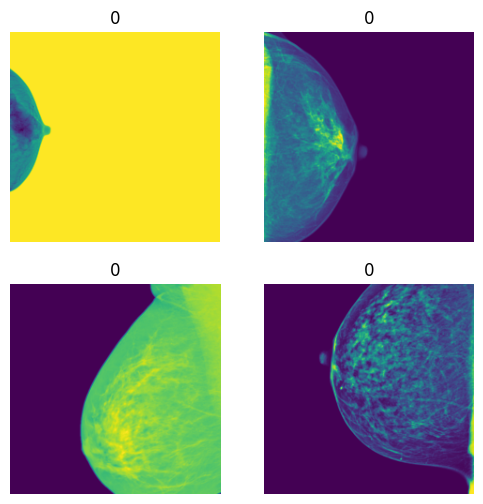

In [ ]:
def get_x(row):
    p = get_dcm_path(row['image_id'], path, 'train_images')
    if p is not None:
        return dcm_to_image(p)
    else:
        raise FileNotFoundError(f"No se encontró la imagen para ID: {row['image_id']}")

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=lambda row: row['cancer'],
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(df_filtered, bs=16)
dls.show_batch(max_n=4)


10. Se realiza entrenamiento del modelo

In [ ]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 259MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.255242,1.492121,0.444444,01:46


epoch,train_loss,valid_loss,accuracy,time
0,1.376715,0.867923,0.555556,01:45
1,1.168772,0.526392,0.666667,01:52


11. Se hacen predicciones sobre el set de prueba

In [ ]:
# Cargar el dataframe del set de prueba
df_test = pd.read_csv(path/'test.csv')
print(f"📁 Imágenes en el set de prueba: {len(df_test)}")

# Función para hacer predicciones con el modelo entrenado
def predict_test_image(image_id):
    dcm_path = get_dcm_path(image_id, path, 'test_images')
    if dcm_path is not None:
        img = dcm_to_image(dcm_path)
        pred, _, probs = learn.predict(img)
        return probs[1].item() # probabilidad de 'cancer' == 1
    else:
        return 0.0  # o np.nan si prefieres marcar como faltante

# Aplicar la predicción a cada imagen del set de prueba
df_test['cancer'] = df_test['image_id'].apply(predict_test_image)

📁 Imágenes en el set de prueba: 4


12. Se genera archivo submission.csv con los resultados de la predicción realizada.

In [ ]:
# Guardar archivo en formato submission de Kaggle
submission_path = path/'submission.csv'
df_test[['image_id', 'cancer']].to_csv(submission_path, index=False)
print(f"✅ Archivo guardado en: {submission_path}")


✅ Archivo guardado en: rsna_data/submission.csv
